
BACKTEST CONFIGURATION
Confidence Threshold: 0.6
Lookahead: 5 days
Initial Capital: 1,000,000 KRW
Dynamic Slippage: Enabled (ATR-based)
Liquidity Constraint: Disabled

WALK-FORWARD VALIDATION PERIOD (FOLD 1-7)


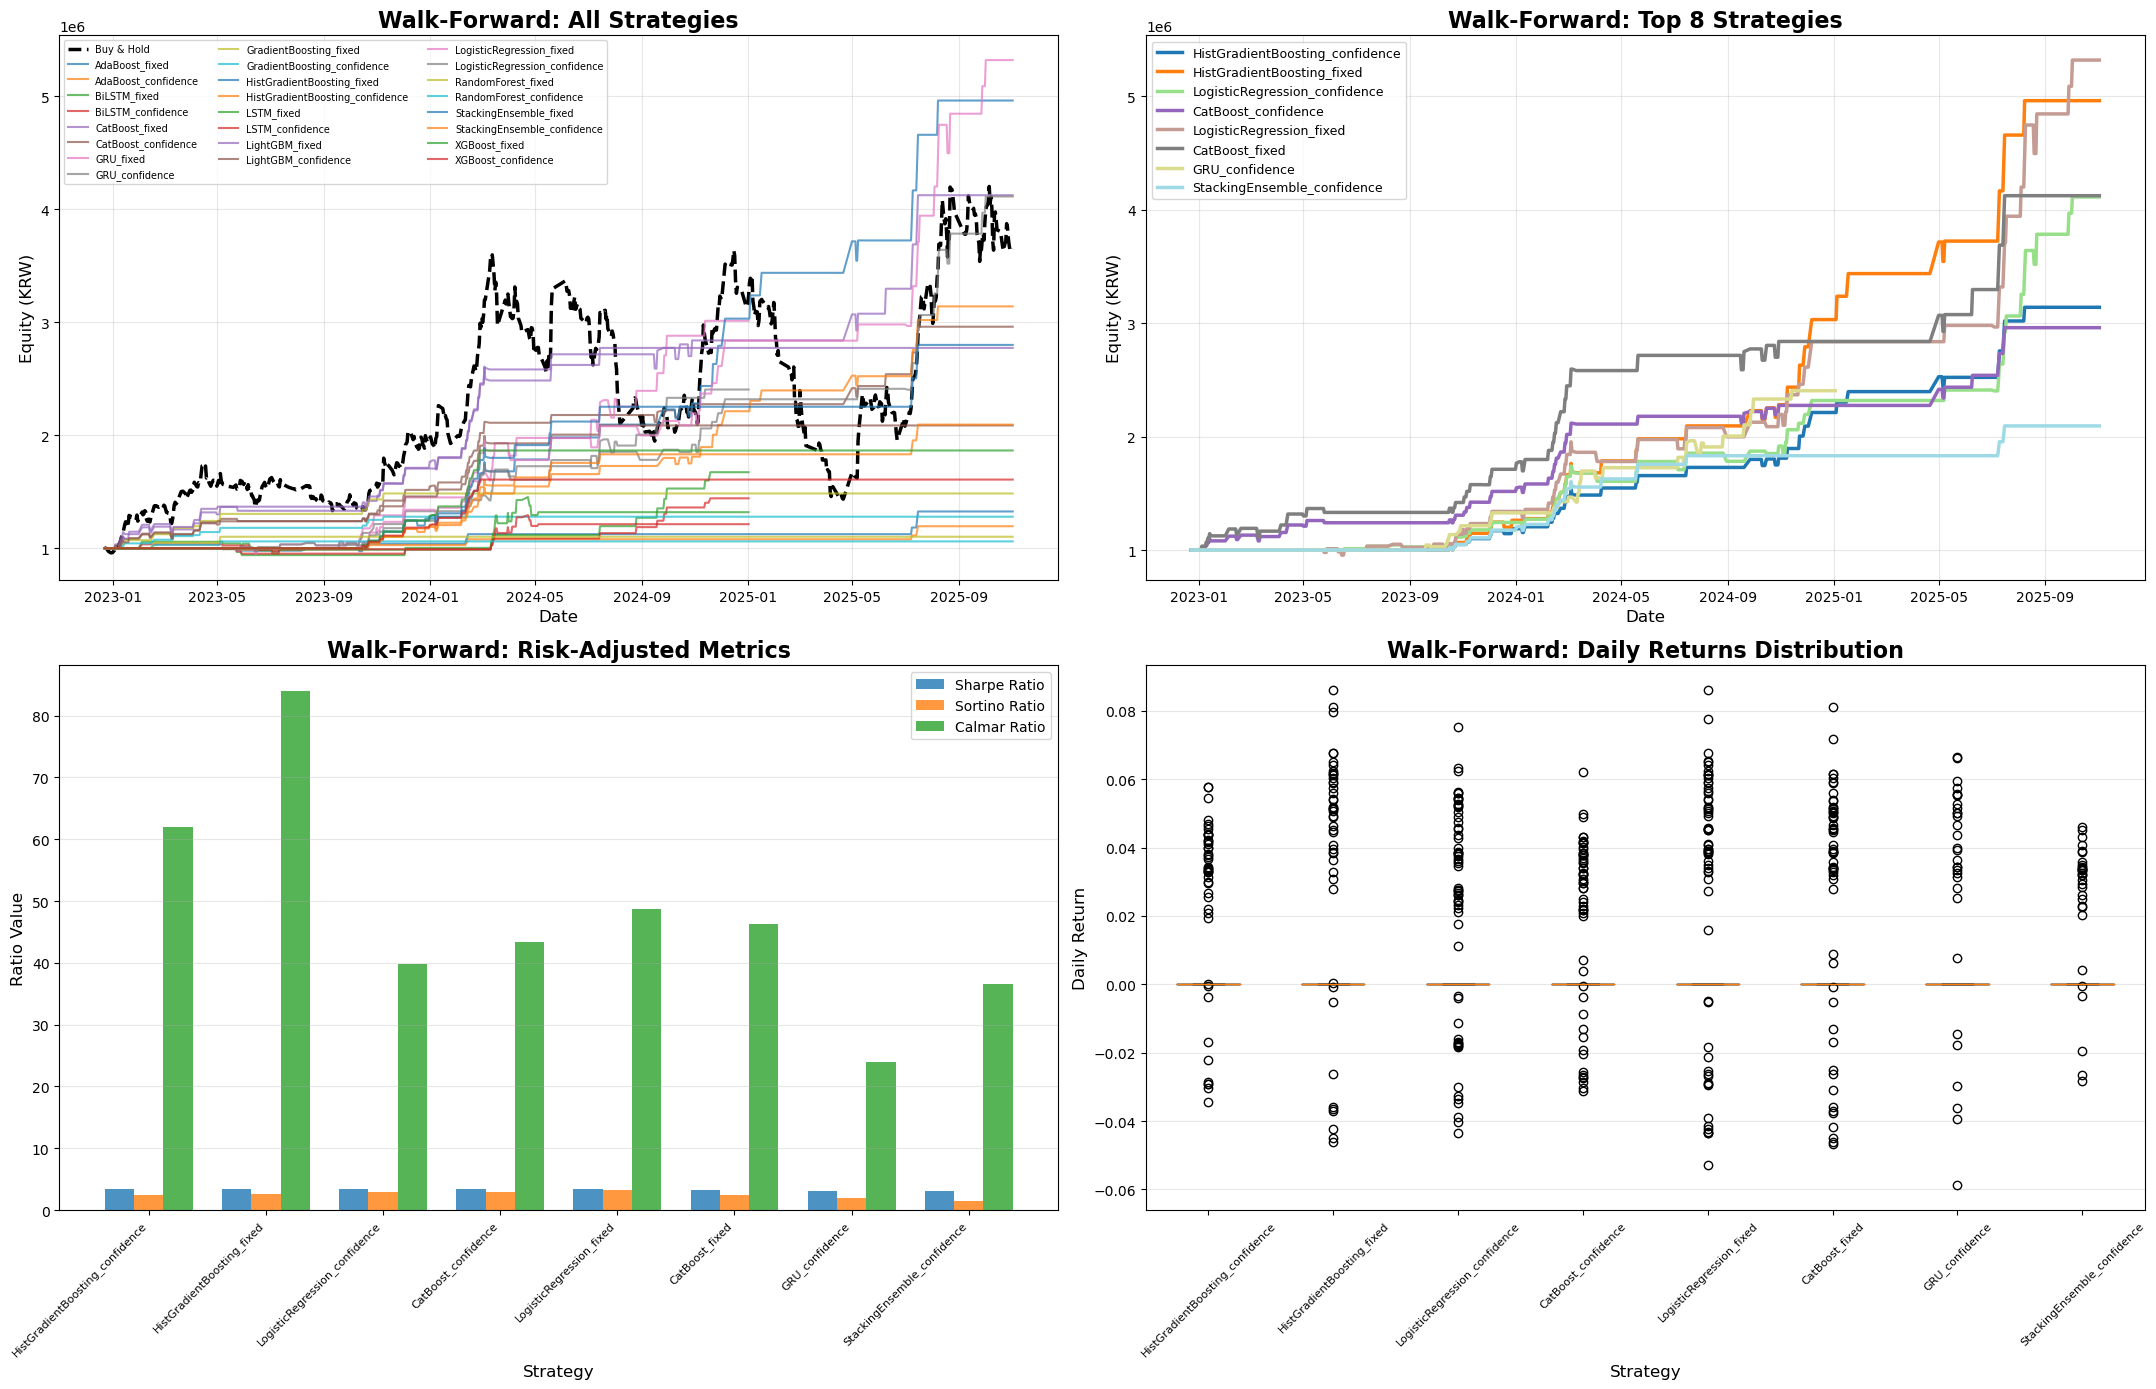


Walk-Forward PERFORMANCE SUMMARY
                                Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Recovery Factor Win Rate Profit Factor   Avg Win  Avg Loss  Avg Trade  Max Consecutive Wins Max Consecutive Losses Total Trades  T-Statistic P-Value Exposure Time  VaR (95%)  CVaR (95%) Avg Trade Duration Stop Loss Rate Take Profit Rate  Time Exit Rate
RandomForest_confidence                 6.06%    0.00%        1.014         0.000        0.000           0.000  100.00%         0.000  0.029409  0.000000   0.000083                     2                      0            2    94.037180  0.0068         0.28%   0.029128    0.029097                2.5          0.00%          100.00%        0.000000
RandomForest_fixed                     10.17%    0.00%        1.014         0.000        0.000           0.000  100.00%         0.000  0.048446  0.000000   0.000136                     2                      0            2    68.596678  0.0093         0.28%   0.047811  

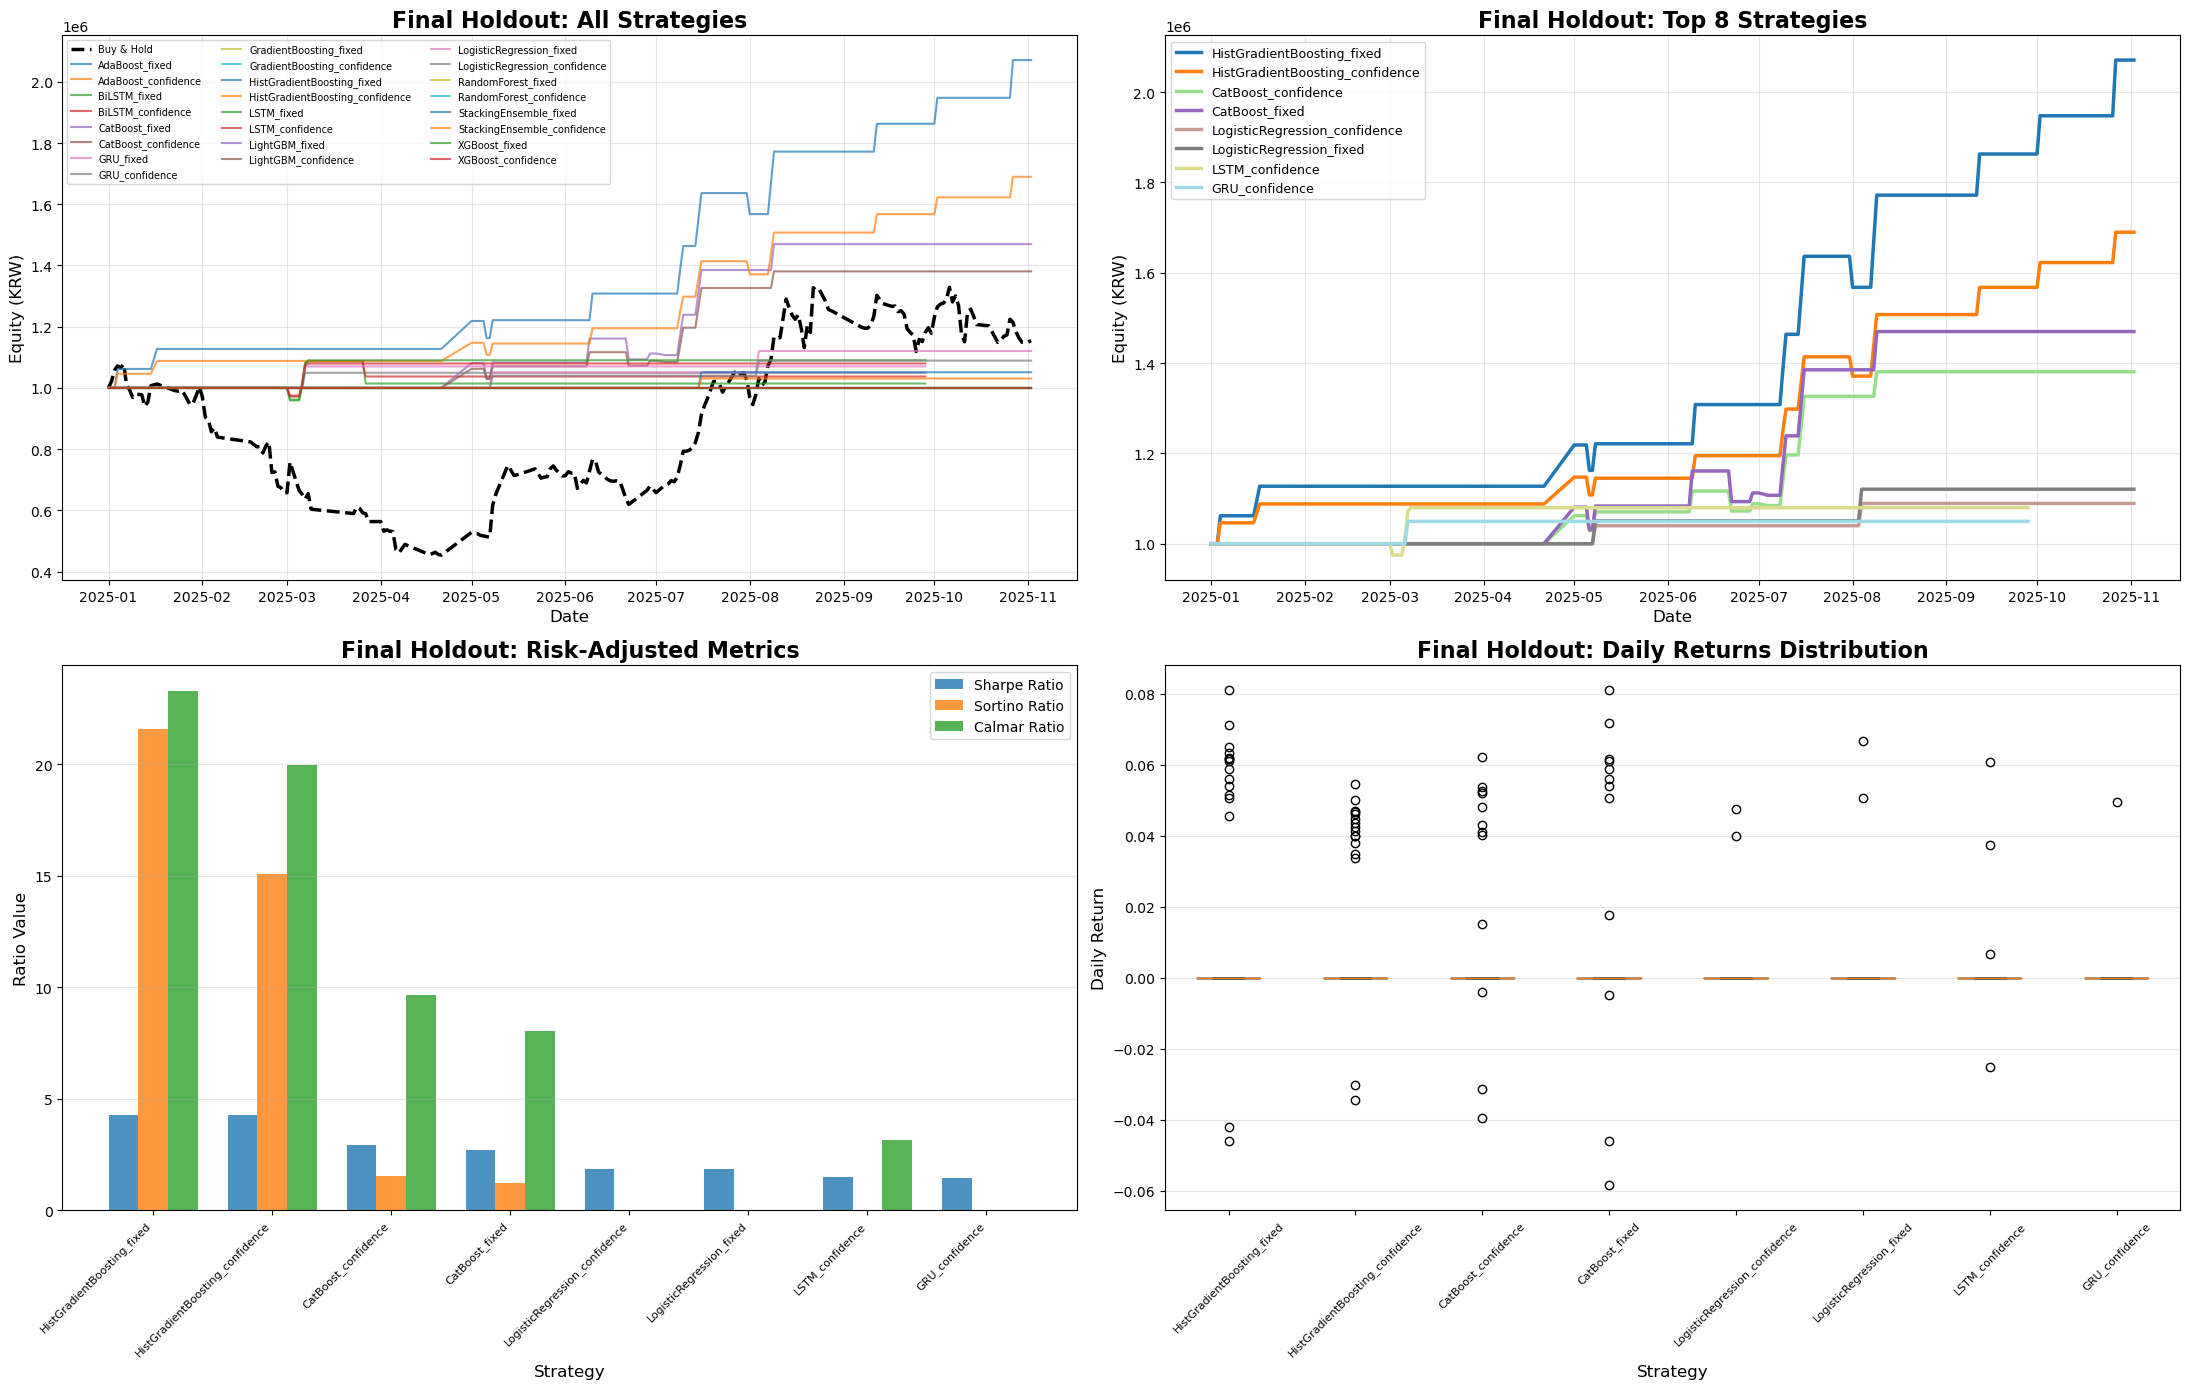


Final Holdout PERFORMANCE SUMMARY
                                Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Recovery Factor Win Rate Profit Factor   Avg Win  Avg Loss  Avg Trade  Max Consecutive Wins Max Consecutive Losses Total Trades  T-Statistic P-Value Exposure Time  VaR (95%)  CVaR (95%) Avg Trade Duration Stop Loss Rate Take Profit Rate  Time Exit Rate
AdaBoost_confidence                     0.00%    0.00%        0.000         0.000        0.000           0.000    0.00%         0.000  0.000000  0.000000   0.000000                     0                      0            0     0.000000  1.0000         0.00%   0.000000    0.000000                0.0          0.00%            0.00%             0.0
RandomForest_fixed                      0.00%    0.00%        0.000         0.000        0.000           0.000    0.00%         0.000  0.000000  0.000000   0.000000                     0                      0            0     0.000000  1.0000         0.00%   0.000000 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats

def calculate_consecutive_metrics(returns_series):
    if len(returns_series) == 0:
        return 0, 0
    wins = (returns_series > 0).astype(int)
    losses = (returns_series < 0).astype(int)
    max_consecutive_wins = 0
    max_consecutive_losses = 0
    current_wins = 0
    current_losses = 0
    for r in returns_series:
        if r > 0:
            current_wins += 1
            current_losses = 0
            max_consecutive_wins = max(max_consecutive_wins, current_wins)
        elif r < 0:
            current_losses += 1
            current_wins = 0
            max_consecutive_losses = max(max_consecutive_losses, current_losses)
        else:
            current_wins = 0
            current_losses = 0
    return max_consecutive_wins, max_consecutive_losses

def calculate_var_cvar(returns, confidence=0.95):
    if len(returns) == 0:
        return 0, 0
    var = np.percentile(returns, (1 - confidence) * 100)
    cvar = returns[returns <= var].mean() if len(returns[returns <= var]) > 0 else var
    return var, cvar

def calculate_performance_metrics(equity_curve, daily_returns, trade_details=None):
    total_returns = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    mdd = drawdown.min()
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(365) if daily_returns.std() != 0 else 0
    downside_returns = daily_returns[daily_returns < 0]
    sortino_ratio = (daily_returns.mean() / downside_returns.std()) * np.sqrt(365) if len(downside_returns) > 0 and downside_returns.std() != 0 else 0
    calmar_ratio = (total_returns / abs(mdd)) if mdd != 0 else 0
    recovery_factor = total_returns / abs(mdd) if mdd != 0 else 0
    non_zero_returns = daily_returns[daily_returns != 0]
    win_rate = len(non_zero_returns[non_zero_returns > 0]) / len(non_zero_returns) if len(non_zero_returns) > 0 else 0
    avg_win = non_zero_returns[non_zero_returns > 0].mean() if len(non_zero_returns[non_zero_returns > 0]) > 0 else 0
    avg_loss = non_zero_returns[non_zero_returns < 0].mean() if len(non_zero_returns[non_zero_returns < 0]) > 0 else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    max_consecutive_wins, max_consecutive_losses = calculate_consecutive_metrics(non_zero_returns)
    t_stat = 0
    p_value = 1
    if len(non_zero_returns) > 1 and non_zero_returns.std() != 0:
        t_stat = (non_zero_returns.mean() / non_zero_returns.std()) * np.sqrt(len(non_zero_returns))
        p_value = stats.t.sf(abs(t_stat), len(non_zero_returns)-1) * 2
    var_95, cvar_95 = calculate_var_cvar(non_zero_returns, 0.95)
    total_trades = len(non_zero_returns)
    exposure_time = total_trades / len(daily_returns) if len(daily_returns) > 0 else 0
    avg_trade_duration = 0
    stop_loss_rate = 0
    take_profit_rate = 0
    time_exit_rate = 0
    if trade_details is not None and len(trade_details) > 0:
        durations = [t['duration'] for t in trade_details if 'duration' in t]
        avg_trade_duration = np.mean(durations) if len(durations) > 0 else 0
        total_exits = len(trade_details)
        stop_loss_exits = len([t for t in trade_details if t.get('exit_reason') == 'stop_loss'])
        take_profit_exits = len([t for t in trade_details if t.get('exit_reason') == 'take_profit'])
        time_exits = len([t for t in trade_details if t.get('exit_reason') == 'time_exit'])
        if total_exits > 0:
            stop_loss_rate = stop_loss_exits / total_exits
            take_profit_rate = take_profit_exits / total_exits
            time_exit_rate = time_exits / total_exits
    return {
        "Total Returns": total_returns,
        "MDD": mdd,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Calmar Ratio": calmar_ratio,
        "Recovery Factor": recovery_factor,
        "Win Rate": win_rate,
        "Profit Factor": profit_factor,
        "Avg Win": avg_win,
        "Avg Loss": avg_loss,
        "Avg Trade": daily_returns.mean(),
        "Max Consecutive Wins": max_consecutive_wins,
        "Max Consecutive Losses": max_consecutive_losses,
        "Total Trades": total_trades,
        "T-Statistic": t_stat,
        "P-Value": p_value,
        "Exposure Time": exposure_time,
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95,
        "Avg Trade Duration": avg_trade_duration,
        "Stop Loss Rate": stop_loss_rate,
        "Take Profit Rate": take_profit_rate,
        "Time Exit Rate": time_exit_rate
    }

def calculate_kelly_criterion(win_rate, avg_win, avg_loss):
    if avg_loss == 0 or win_rate == 0:
        return 0
    win_loss_ratio = abs(avg_win / avg_loss)
    kelly = (win_rate * win_loss_ratio - (1 - win_rate)) / win_loss_ratio
    return max(0, min(kelly, 0.25))

def calculate_dynamic_slippage(price_df, current_idx, base_slippage=0.0005, atr_window=14):
    if current_idx < atr_window:
        return base_slippage
    recent_data = price_df.iloc[max(0, current_idx - atr_window):current_idx + 1]
    tr1 = recent_data['ETH_High'] - recent_data['ETH_Low']
    tr2 = abs(recent_data['ETH_High'] - recent_data['ETH_Close'].shift(1))
    tr3 = abs(recent_data['ETH_Low'] - recent_data['ETH_Close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    current_atr = tr.mean()
    atr_ratio = current_atr / recent_data['ETH_Close'].iloc[-1]
    volume_ratio = 1.0
    if 'ETH_Volume' in recent_data.columns:
        avg_volume = recent_data['ETH_Volume'].mean()
        current_volume = recent_data['ETH_Volume'].iloc[-1]
        volume_ratio = current_volume / avg_volume if avg_volume > 0 else 1.0
    atr_multiplier = min(atr_ratio / 0.02, 3.0)
    volume_multiplier = max(0.5, min(2.0 / volume_ratio, 2.0)) if volume_ratio < 1 else 1.0
    dynamic_slippage = base_slippage * (1 + atr_multiplier * 0.5 + (volume_multiplier - 1) * 0.3)
    return min(dynamic_slippage, base_slippage * 5)

def check_liquidity_constraint(price_df, current_idx, capital_krw, min_volume_ratio=0.01):
    if 'ETH_Volume' in price_df.columns:
        current_price = price_df.loc[current_idx, 'ETH_Close']
        daily_volume_krw = price_df.loc[current_idx, 'ETH_Volume'] * current_price
        if capital_krw > daily_volume_krw * min_volume_ratio:
            return False
    return True

def dynamic_position_sizing(predictions_df, price_df, lookahead, sizing_method='fixed', 
                           fee_rate=0.0005, base_slippage=0.0005, 
                           use_dynamic_slippage=True, use_liquidity_constraint=False,
                           capital=1_000_000):
    predictions_df['date'] = pd.to_datetime(predictions_df['date'])
    sim_df = pd.merge(predictions_df, price_df, on='date', how='inner').sort_values(by='date').reset_index(drop=True)
    daily_log_returns = pd.Series(0.0, index=sim_df.index)
    position = None
    trade_details = []
    for i in range(len(sim_df)):
        current_slippage = calculate_dynamic_slippage(sim_df, i, base_slippage) if use_dynamic_slippage else base_slippage
        if position:
            days_in_trade = i - position['entry_day_index']
            exit_price = None
            exit_reason = None
            if sim_df.loc[i, 'ETH_Low'] <= position['stop_loss']:
                exit_price = position['stop_loss']
                exit_reason = 'stop_loss'
            elif sim_df.loc[i, 'ETH_High'] >= position['take_profit']:
                exit_price = position['take_profit']
                exit_reason = 'take_profit'
            elif days_in_trade >= lookahead:
                if i + 1 < len(sim_df):
                    exit_price = sim_df.loc[i + 1, 'ETH_Open']
                else:
                    exit_price = sim_df.loc[i, 'ETH_Close']
                exit_reason = 'time_exit'
            if exit_price:
                total_cost = current_slippage + fee_rate
                actual_exit_price = exit_price * (1 - total_cost)
                trade_return = np.log(actual_exit_price / position['entry_price'])
                daily_log_returns.iloc[i] = trade_return * position['size']
                trade_details.append({
                    'return': trade_return * position['size'],
                    'exit_reason': exit_reason,
                    'duration': days_in_trade,
                    'entry_date': position['entry_date'],
                    'exit_date': sim_df.loc[i, 'date']
                })
                position = None
        if not position and sim_df.loc[i, 'signal'] == 1 and (i + 1 < len(sim_df)):
            if use_liquidity_constraint and not check_liquidity_constraint(sim_df, i, capital):
                continue
            if sizing_method == 'fixed':
                position_size = 1.0
            elif sizing_method == 'confidence':
                position_size = sim_df.loc[i, 'confidence']
            elif sizing_method == 'kelly' and len(trade_details) >= 20:
                recent_trades = [t['return'] for t in trade_details[-20:]]
                recent_series = pd.Series(recent_trades)
                win_rate = len(recent_series[recent_series > 0]) / len(recent_series)
                avg_win = recent_series[recent_series > 0].mean() if len(recent_series[recent_series > 0]) > 0 else 0
                avg_loss = recent_series[recent_series < 0].mean() if len(recent_series[recent_series < 0]) > 0 else 0
                position_size = calculate_kelly_criterion(win_rate, avg_win, avg_loss)
            else:
                position_size = 1.0
            entry_slippage = calculate_dynamic_slippage(sim_df, i + 1, base_slippage) if use_dynamic_slippage else base_slippage
            total_entry_cost = entry_slippage + fee_rate
            entry_price = sim_df.loc[i + 1, 'ETH_Open'] * (1 + total_entry_cost)
            position = {
                'entry_price': entry_price,
                'take_profit': sim_df.loc[i, 'take_profit_price'],
                'stop_loss': sim_df.loc[i, 'stop_loss_price'],
                'entry_day_index': i + 1,
                'entry_date': sim_df.loc[i + 1, 'date'],
                'size': position_size
            }
    return daily_log_returns, trade_details

def run_separated_backtest(pred_base_path, master_raw_file_path, confidence_threshold=0.5, 
                           lookahead=5, initial_capital=1_000_000,
                           use_dynamic_slippage=True, use_liquidity_constraint=False):
    price_df = pd.read_csv(master_raw_file_path, usecols=['date', 'ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close'])
    price_df['date'] = pd.to_datetime(price_df['date'])
    all_pred_files = glob.glob(os.path.join(pred_base_path, "fold_*", "*_predictions.csv"))
    wf_files = [f for f in all_pred_files if 'final_holdout' not in f]
    ho_files = [f for f in all_pred_files if 'final_holdout' in f]
    wf_model_files = {}
    for f in wf_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        if model_name not in wf_model_files:
            wf_model_files[model_name] = []
        wf_model_files[model_name].append(f)
    ho_model_files = {}
    for f in ho_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        if model_name not in ho_model_files:
            ho_model_files[model_name] = []
        ho_model_files[model_name].append(f)
    
    def backtest_period(model_files_dict, period_name):
        all_dates_df = pd.concat([pd.read_csv(f)[['date']] for files in model_files_dict.values() for f in files]).drop_duplicates().sort_values('date')
        all_test_dates = pd.to_datetime(all_dates_df['date'])
        performance_summary = {}
        all_equity_curves = {}
        bnh_df = price_df[price_df['date'].isin(all_test_dates)].copy().reset_index(drop=True)
        bnh_df['bnh_return'] = np.log(bnh_df['ETH_Close'] / bnh_df['ETH_Close'].shift(1)).fillna(0)
        bnh_equity = initial_capital * np.exp(bnh_df['bnh_return'].cumsum())
        bnh_metrics = calculate_performance_metrics(bnh_equity, bnh_df['bnh_return'])
        performance_summary['Buy_Hold'] = bnh_metrics
        all_equity_curves['Buy_Hold'] = bnh_equity
        for model_name, files in sorted(model_files_dict.items()):
            preds_df = pd.concat([pd.read_csv(f) for f in files]).drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)
            preds_df['signal'] = np.where((preds_df['pred_direction'] == 1) & (preds_df['confidence'] >= confidence_threshold), 1, 0)
            for sizing_method in ['fixed', 'confidence']:
                strategy_log_returns, trade_details = dynamic_position_sizing(
                    preds_df, price_df, lookahead, 
                    sizing_method=sizing_method,
                    use_dynamic_slippage=use_dynamic_slippage,
                    use_liquidity_constraint=use_liquidity_constraint,
                    capital=initial_capital
                )
                strategy_equity = initial_capital * np.exp(strategy_log_returns.cumsum())
                if len(strategy_equity) > 0:
                    strategy_key = f"{model_name}_{sizing_method}"
                    performance_summary[strategy_key] = calculate_performance_metrics(strategy_equity, strategy_log_returns, trade_details)
                    all_equity_curves[strategy_key] = strategy_equity
        
        fig, axes = plt.subplots(2, 2, figsize=(22, 14))
        axes[0, 0].plot(bnh_df['date'], bnh_equity, label='Buy & Hold', color='black', linestyle='--', linewidth=2.5)
        for strategy_name, equity in all_equity_curves.items():
            if strategy_name != 'Buy_Hold':
                axes[0, 0].plot(bnh_df['date'][:len(equity)], equity, label=strategy_name, alpha=0.7, linewidth=1.5)
        axes[0, 0].set_title(f'{period_name}: All Strategies', fontsize=16, fontweight='bold')
        axes[0, 0].set_xlabel('Date', fontsize=12)
        axes[0, 0].set_ylabel('Equity (KRW)', fontsize=12)
        axes[0, 0].legend(loc='upper left', fontsize=7, ncol=3)
        axes[0, 0].grid(True, alpha=0.3)
        
        summary_df = pd.DataFrame.from_dict(performance_summary, orient='index')
        summary_df = summary_df.sort_values('Sharpe Ratio', ascending=False)
        top_strategies = summary_df.head(8).index.tolist()
        colors = plt.cm.tab20(np.linspace(0, 1, len(top_strategies)))
        for idx, strategy in enumerate(top_strategies):
            if strategy in all_equity_curves:
                dates = bnh_df['date'][:len(all_equity_curves[strategy])]
                axes[0, 1].plot(dates, all_equity_curves[strategy], label=strategy, linewidth=2.5, color=colors[idx])
        axes[0, 1].set_title(f'{period_name}: Top 8 Strategies', fontsize=16, fontweight='bold')
        axes[0, 1].set_xlabel('Date', fontsize=12)
        axes[0, 1].set_ylabel('Equity (KRW)', fontsize=12)
        axes[0, 1].legend(loc='upper left', fontsize=9)
        axes[0, 1].grid(True, alpha=0.3)
        
        metrics = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio']
        x = np.arange(len(top_strategies))
        width = 0.25
        for idx, metric in enumerate(metrics):
            values = [summary_df.loc[s, metric] if s in summary_df.index else 0 for s in top_strategies]
            axes[1, 0].bar(x + idx * width, values, width, label=metric, alpha=0.8)
        axes[1, 0].set_xlabel('Strategy', fontsize=12)
        axes[1, 0].set_ylabel('Ratio Value', fontsize=12)
        axes[1, 0].set_title(f'{period_name}: Risk-Adjusted Metrics', fontsize=16, fontweight='bold')
        axes[1, 0].set_xticks(x + width)
        axes[1, 0].set_xticklabels(top_strategies, rotation=45, ha='right', fontsize=8)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        returns_data = []
        strategy_labels = []
        for strategy in top_strategies:
            if strategy in all_equity_curves:
                rets = pd.Series(all_equity_curves[strategy]).pct_change().dropna()
                returns_data.append(rets)
                strategy_labels.append(strategy)
        axes[1, 1].boxplot(returns_data, labels=strategy_labels)
        axes[1, 1].set_title(f'{period_name}: Daily Returns Distribution', fontsize=16, fontweight='bold')
        axes[1, 1].set_xlabel('Strategy', fontsize=12)
        axes[1, 1].set_ylabel('Daily Return', fontsize=12)
        axes[1, 1].tick_params(axis='x', rotation=45, labelsize=8)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*120)
        print(f"{period_name} PERFORMANCE SUMMARY")
        print("="*120)
        display_df = summary_df[['Total Returns', 'MDD', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio',
                                 'Recovery Factor', 'Win Rate', 'Profit Factor', 'Max Consecutive Losses',
                                 'Total Trades', 'P-Value', 'Exposure Time', 'Stop Loss Rate', 
                                 'Take Profit Rate', 'Avg Trade Duration']].copy()
        display_df=summary_df.sort_values('Total Returns',ascending=True)
        display_df['Total Returns'] = display_df['Total Returns'].apply(lambda x: f"{x:.2%}")
        display_df['MDD'] = display_df['MDD'].apply(lambda x: f"{x:.2%}")
        display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Sortino Ratio'] = display_df['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Calmar Ratio'] = display_df['Calmar Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Recovery Factor'] = display_df['Recovery Factor'].apply(lambda x: f"{x:.3f}")
        display_df['Win Rate'] = display_df['Win Rate'].apply(lambda x: f"{x:.2%}")
        display_df['Profit Factor'] = display_df['Profit Factor'].apply(lambda x: f"{x:.3f}")
        display_df['Max Consecutive Losses'] = display_df['Max Consecutive Losses'].apply(lambda x: f"{int(x)}")
        display_df['Total Trades'] = display_df['Total Trades'].apply(lambda x: f"{int(x)}")
        display_df['P-Value'] = display_df['P-Value'].apply(lambda x: f"{x:.4f}")
        display_df['Exposure Time'] = display_df['Exposure Time'].apply(lambda x: f"{x:.2%}")
        display_df['Stop Loss Rate'] = display_df['Stop Loss Rate'].apply(lambda x: f"{x:.2%}")
        display_df['Take Profit Rate'] = display_df['Take Profit Rate'].apply(lambda x: f"{x:.2%}")
        display_df['Avg Trade Duration'] = display_df['Avg Trade Duration'].apply(lambda x: f"{x:.1f}")
        print(display_df.to_string())
        print("="*120)
        return performance_summary
    
    print("\n" + "="*120)
    print(f"BACKTEST CONFIGURATION")
    print("="*120)
    print(f"Confidence Threshold: {confidence_threshold}")
    print(f"Lookahead: {lookahead} days")
    print(f"Initial Capital: {initial_capital:,} KRW")
    print(f"Dynamic Slippage: {'Enabled (ATR-based)' if use_dynamic_slippage else 'Disabled (Fixed 0.05%)'}")
    print(f"Liquidity Constraint: {'Enabled' if use_liquidity_constraint else 'Disabled'}")
    print("="*120)
    
    print("\n" + "="*120)
    print("WALK-FORWARD VALIDATION PERIOD (FOLD 1-7)")
    print("="*120)
    wf_summary = backtest_period(wf_model_files, "Walk-Forward")
    
    print("\n" + "="*120)
    print("FINAL HOLDOUT PERIOD (FOLD 8)")
    print("="*120)
    ho_summary = backtest_period(ho_model_files, "Final Holdout")


pred_base_path = "../model_results/2025-11-10/fold_results/direction_l5_p1.5_s1.0"
master_raw_file_path = "../model_results/2025-11-09/raw_data/direction/walk_forward/raw_data_all_features.csv"
run_separated_backtest(
    pred_base_path, 
    master_raw_file_path, 
    confidence_threshold=0.6, 
    lookahead=5,
    initial_capital=1_000_000,
    use_dynamic_slippage=True,
    use_liquidity_constraint=False
)


In [26]:
import pandas as pd
import glob
import os

def count_signals_by_model(pred_base_path):
    all_pred_files = glob.glob(os.path.join(pred_base_path, "fold_*", "*_predictions.csv"))
    
    model_signal_counts = {}
    
    for f in all_pred_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        if model_name not in model_signal_counts:
            model_signal_counts[model_name] = {'signal_1': 0, 'signal_0': 0}
        
        df = pd.read_csv(f)
        df['signal'] = (df['pred_direction'] == 1).astype(int)  # signal 1/0로 변환
        counts = df['signal'].value_counts()
        model_signal_counts[model_name]['signal_1'] += counts.get(1, 0)
        model_signal_counts[model_name]['signal_0'] += counts.get(0, 0)
    
    return model_signal_counts

# 사용 예시
pred_base_path = "../model_results/2025-11-10/fold_results/direction_l5_p2.0_s1.0"
signal_counts = count_signals_by_model(pred_base_path)

for model, counts in signal_counts.items():
    print(f"{model}: signal_1={counts['signal_1']}, signal_0={counts['signal_0']}")


StackingEnsemble: signal_1=289, signal_0=540
HistGradientBoosting: signal_1=293, signal_0=536
RandomForest: signal_1=206, signal_0=623
BiLSTM: signal_1=123, signal_0=466
AdaBoost: signal_1=266, signal_0=563
CatBoost: signal_1=281, signal_0=548
LightGBM: signal_1=310, signal_0=519
GradientBoosting: signal_1=249, signal_0=580
LogisticRegression: signal_1=247, signal_0=582
LSTM: signal_1=157, signal_0=432
GRU: signal_1=203, signal_0=386
XGBoost: signal_1=225, signal_0=604


In [30]:
import pandas as pd
import glob
import os

def calculate_recall_precision(pred_base_path):
    all_pred_files = glob.glob(os.path.join(pred_base_path, "fold_*", "*_predictions.csv"))
    
    model_metrics = {}
    
    for f in all_pred_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        if model_name not in model_metrics:
            model_metrics[model_name] = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
        
        df = pd.read_csv(f)
        df['signal'] = (df['pred_direction'] == 1).astype(int)
        df['actual'] = (df['actual_direction'] == 1).astype(int)
        
        # True Positive (신호 1, 실제 1)
        TP = ((df['signal'] == 1) & (df['actual'] == 1)).sum()
        # False Positive (신호 1, 실제 0)
        FP = ((df['signal'] == 1) & (df['actual'] == 0)).sum()
        # True Negative (신호 0, 실제 0)
        TN = ((df['signal'] == 0) & (df['actual'] == 0)).sum()
        # False Negative (신호 0, 실제 1)
        FN = ((df['signal'] == 0) & (df['actual'] == 1)).sum()
        
        model_metrics[model_name]['TP'] += TP
        model_metrics[model_name]['FP'] += FP
        model_metrics[model_name]['TN'] += TN
        model_metrics[model_name]['FN'] += FN
    
    # Recall과 Precision 계산
    for model, metrics in model_metrics.items():
        TP = metrics['TP']
        FP = metrics['FP']
        TN = metrics['TN']
        FN = metrics['FN']
        
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        accuracy= (TP+TN)/(TP+FP+TN+FN) 
        print(f"{model}: Accuracy={accuracy:.2%}, Recall={recall:.2%}, Precision={precision:.2%}")
    
    return model_metrics

pred_base_path = "../model_results/2025-11-10/fold_results/direction_l5_p2.0_s1.0"
metrics = calculate_recall_precision(pred_base_path)


StackingEnsemble: Accuracy=82.75%, Recall=77.44%, Precision=71.28%
HistGradientBoosting: Accuracy=83.47%, Recall=79.32%, Precision=72.01%
RandomForest: Accuracy=79.98%, Recall=57.52%, Precision=74.27%
BiLSTM: Accuracy=68.59%, Recall=32.97%, Precision=48.78%
AdaBoost: Accuracy=83.35%, Recall=74.06%, Precision=74.06%
CatBoost: Accuracy=84.20%, Recall=78.20%, Precision=74.02%
LightGBM: Accuracy=80.94%, Recall=78.57%, Precision=67.42%
GradientBoosting: Accuracy=82.75%, Recall=69.92%, Precision=74.70%
LogisticRegression: Accuracy=83.47%, Recall=70.68%, Precision=76.11%
LSTM: Accuracy=69.61%, Recall=43.96%, Precision=50.96%
GRU: Accuracy=73.34%, Recall=62.64%, Precision=56.16%
XGBoost: Accuracy=78.41%, Recall=58.65%, Precision=69.33%


In [31]:
import pandas as pd
import glob
import os

def calculate_recall_precision(pred_base_path):
    all_pred_files = glob.glob(os.path.join(pred_base_path, "fold_*", "*_predictions.csv"))
    
    model_metrics = {}
    
    for f in all_pred_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        if model_name not in model_metrics:
            model_metrics[model_name] = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
        
        df = pd.read_csv(f)
        df['signal'] = (df['pred_direction'] == 1).astype(int)
        df['actual'] = (df['actual_direction'] == 1).astype(int)
        
        # True Positive (신호 1, 실제 1)
        TP = ((df['signal'] == 1) & (df['actual'] == 1)).sum()
        # False Positive (신호 1, 실제 0)
        FP = ((df['signal'] == 1) & (df['actual'] == 0)).sum()
        # True Negative (신호 0, 실제 0)
        TN = ((df['signal'] == 0) & (df['actual'] == 0)).sum()
        # False Negative (신호 0, 실제 1)
        FN = ((df['signal'] == 0) & (df['actual'] == 1)).sum()
        
        model_metrics[model_name]['TP'] += TP
        model_metrics[model_name]['FP'] += FP
        model_metrics[model_name]['TN'] += TN
        model_metrics[model_name]['FN'] += FN
    
    # Recall과 Precision 계산
    for model, metrics in model_metrics.items():
        TP = metrics['TP']
        FP = metrics['FP']
        TN = metrics['TN']
        FN = metrics['FN']
        
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        accuracy= (TP+TN)/(TP+FP+TN+FN) 
        print(f"{model}: Accuracy={accuracy:.2%}, Recall={recall:.2%}, Precision={precision:.2%}")
    
    return model_metrics

pred_base_path = "../model_results/2025-10-26/fold_results/direction"
metrics = calculate_recall_precision(pred_base_path)


VotingSoft: Accuracy=62.43%, Recall=64.09%, Precision=62.89%
LSTM_Attention: Accuracy=51.09%, Recall=44.52%, Precision=52.72%
StackingEnsemble: Accuracy=62.80%, Recall=66.28%, Precision=62.79%
KNN: Accuracy=54.39%, Recall=45.26%, Precision=56.57%
HistGradientBoosting: Accuracy=63.47%, Recall=66.13%, Precision=63.62%
TCN: Accuracy=50.00%, Recall=34.98%, Precision=51.83%
SVM: Accuracy=57.37%, Recall=62.34%, Precision=57.55%
Hybrid_LSTM_GRU: Accuracy=53.53%, Recall=59.89%, Precision=54.24%
MLP: Accuracy=60.19%, Recall=65.40%, Precision=60.05%
RandomForest: Accuracy=63.39%, Recall=64.96%, Precision=63.85%
BiLSTM: Accuracy=56.61%, Recall=78.45%, Precision=55.43%
AdaBoost: Accuracy=60.57%, Recall=60.15%, Precision=61.58%
CatBoost: Accuracy=63.17%, Recall=63.36%, Precision=64.01%
VotingHard: Accuracy=61.38%, Recall=58.69%, Precision=63.01%
DecisionTree: Accuracy=61.98%, Recall=62.19%, Precision=62.83%
ExtraTrees: Accuracy=55.43%, Recall=63.80%, Precision=55.46%
LightGBM: Accuracy=61.61%, Reca

                      Total Returns       MDD  Sharpe Ratio  Sortino Ratio  \
LogisticRegression         2.721877 -0.083529      2.570513       1.283494   
HistGradientBoosting       2.220204 -0.045535      2.810419       1.526576   
CatBoost                   2.177015 -0.067288      2.683110       1.278380   
GRU                        1.665093 -0.056508      2.224199       1.192615   
StackingEnsemble           1.074208 -0.030033      2.529945       1.031276   
LightGBM                   1.041228 -0.044456      2.429213       1.477918   
XGBoost                    0.571792 -0.019251      2.151716       0.623473   
BiLSTM                     0.543089 -0.062106      1.427703       0.680934   
GradientBoosting           0.254256  0.000000      1.798749       0.000000   
LSTM                       0.241494 -0.119813      0.691590       0.216860   
AdaBoost                   0.144148 -0.012866      1.333250       0.327457   
RandomForest               0.030075  0.000000      0.590719     

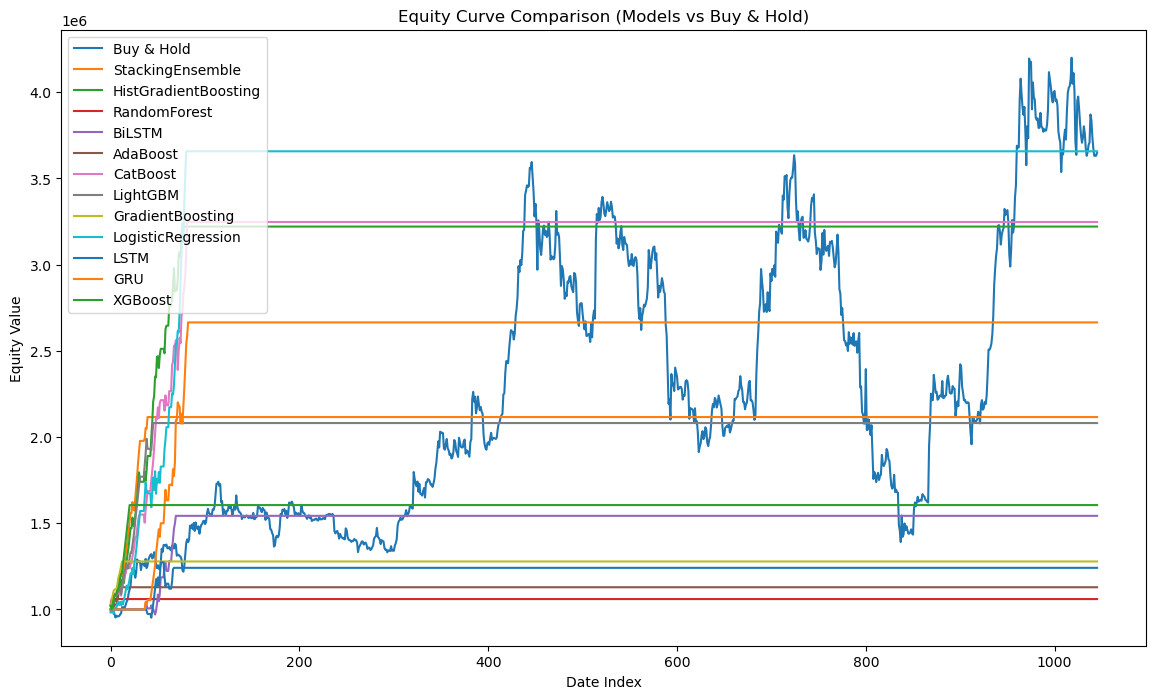

In [47]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy import stats

def calculate_performance_metrics(equity_curve, daily_returns, trade_details=None):
    total_returns = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    mdd = drawdown.min()
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(365) if daily_returns.std() != 0 else 0
    downside_returns = daily_returns[daily_returns < 0]
    sortino_ratio = (daily_returns.mean() / downside_returns.std()) * np.sqrt(365) if len(downside_returns) > 0 and downside_returns.std() != 0 else 0
    calmar_ratio = (total_returns / abs(mdd)) if mdd != 0 else 0
    recovery_factor = total_returns / abs(mdd) if mdd != 0 else 0
    non_zero_returns = daily_returns[daily_returns != 0]
    win_rate = len(non_zero_returns[non_zero_returns > 0]) / len(non_zero_returns) if len(non_zero_returns) > 0 else 0
    avg_win = non_zero_returns[non_zero_returns > 0].mean() if len(non_zero_returns[non_zero_returns > 0]) > 0 else 0
    avg_loss = non_zero_returns[non_zero_returns < 0].mean() if len(non_zero_returns[non_zero_returns < 0]) > 0 else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    max_consecutive_wins = 0
    max_consecutive_losses = 0
    current_wins = current_losses = 0
    for r in non_zero_returns:
        if r > 0:
            current_wins += 1
            current_losses = 0
            max_consecutive_wins = max(max_consecutive_wins, current_wins)
        elif r < 0:
            current_losses += 1
            current_wins = 0
            max_consecutive_losses = max(max_consecutive_losses, current_losses)
        else:
            current_wins = 0
            current_losses = 0
    t_stat, p_value = 0, 1
    if len(non_zero_returns) > 1 and non_zero_returns.std() != 0:
        t_stat = (non_zero_returns.mean() / non_zero_returns.std()) * np.sqrt(len(non_zero_returns))
        p_value = stats.t.sf(abs(t_stat), len(non_zero_returns)-1) * 2
    var_95 = np.percentile(non_zero_returns, 5) if len(non_zero_returns) > 0 else 0
    cvar_95 = non_zero_returns[non_zero_returns <= var_95].mean() if len(non_zero_returns[non_zero_returns <= var_95]) > 0 else var_95
    total_trades = len(non_zero_returns)
    exposure_time = total_trades / len(daily_returns) if len(daily_returns) > 0 else 0
    avg_trade_duration = np.mean([t['duration'] for t in trade_details]) if trade_details else 0
    stop_loss_rate = sum(1 for t in (trade_details or []) if t.get('exit_reason') == 'stop_loss') / total_trades if total_trades > 0 else 0
    take_profit_rate = sum(1 for t in (trade_details or []) if t.get('exit_reason') == 'take_profit') / total_trades if total_trades > 0 else 0
    time_exit_rate = sum(1 for t in (trade_details or []) if t.get('exit_reason') == 'time_exit') / total_trades if total_trades > 0 else 0
    return {
        "Total Returns": total_returns,
        "MDD": mdd,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Calmar Ratio": calmar_ratio,
        "Recovery Factor": recovery_factor,
        "Win Rate": win_rate,
        "Profit Factor": profit_factor,
        "Avg Win": avg_win,
        "Avg Loss": avg_loss,
        "Avg Trade": daily_returns.mean(),
        "Max Consecutive Wins": max_consecutive_wins,
        "Max Consecutive Losses": max_consecutive_losses,
        "Total Trades": total_trades,
        "T-Statistic": t_stat,
        "P-Value": p_value,
        "Exposure Time": exposure_time,
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95,
        "Avg Trade Duration": avg_trade_duration,
        "Stop Loss Rate": stop_loss_rate,
        "Take Profit Rate": take_profit_rate,
        "Time Exit Rate": time_exit_rate
    }

def calculate_dynamic_holding_period(confidence, base_lookahead=5):
    if confidence >= 0.7:
        return int(base_lookahead * 1.5)
    elif confidence >= 0.6:
        return base_lookahead
    elif confidence >= 0.3:
        return int(base_lookahead * 0.6)
    else:
        return max(1, int(base_lookahead * 0.4))

def calculate_dynamic_slippage(price_df, current_idx, base_slippage=0.0005, atr_window=14):
    if current_idx < atr_window:
        return base_slippage
    recent_data = price_df.iloc[max(0, current_idx - atr_window):current_idx + 1]
    tr1 = recent_data['ETH_High'] - recent_data['ETH_Low']
    tr2 = abs(recent_data['ETH_High'] - recent_data['ETH_Close'].shift(1))
    tr3 = abs(recent_data['ETH_Low'] - recent_data['ETH_Close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    current_atr = tr.mean()
    atr_ratio = current_atr / recent_data['ETH_Close'].iloc[-1]
    volume_ratio = 1.0
    if 'ETH_Volume' in recent_data.columns:
        avg_volume = recent_data['ETH_Volume'].mean()
        current_volume = recent_data['ETH_Volume'].iloc[-1]
        volume_ratio = current_volume / avg_volume if avg_volume > 0 else 1.0
    atr_multiplier = min(atr_ratio / 0.02, 3.0)
    volume_multiplier = max(0.5, min(2.0 / volume_ratio, 2.0)) if volume_ratio < 1 else 1.0
    dynamic_slippage = base_slippage * (1 + atr_multiplier * 0.5 + (volume_multiplier - 1) * 0.3)
    return min(dynamic_slippage, base_slippage * 5)

def dynamic_position_sizing(predictions_df, price_df, base_lookahead=5, 
                           sizing_method='fixed', fee_rate=0.0005, base_slippage=0.0005, 
                           use_dynamic_slippage=True, initial_capital=1_000_000):
    predictions_df['date'] = pd.to_datetime(predictions_df['date'])
    sim_df = pd.merge(predictions_df, price_df, on='date', how='inner').sort_values(by='date').reset_index(drop=True)
    daily_log_returns = pd.Series(0.0, index=sim_df.index)
    position = None
    trade_details = []
    equity_curve =[]
    capital = initial_capital
    for i in range(len(sim_df)):
        current_slippage = calculate_dynamic_slippage(sim_df, i, base_slippage) if use_dynamic_slippage else base_slippage
        if position:
            days_in_trade = i - position['entry_day_index']
            exit_price = None
            exit_reason = None
            if sim_df.loc[i, 'ETH_Low'] <= position['stop_loss']:
                exit_price = position['stop_loss']
                exit_reason = 'stop_loss'
            elif sim_df.loc[i, 'ETH_High'] >= position['take_profit']:
                exit_price = position['take_profit']
                exit_reason = 'take_profit'
            elif days_in_trade >= position['holding_days']:
                if i + 1 < len(sim_df):
                    exit_price = sim_df.loc[i + 1, 'ETH_Open']
                else:
                    exit_price = sim_df.loc[i, 'ETH_Close']
                exit_reason = 'time_exit'
            if exit_price:
                total_cost = current_slippage + fee_rate
                actual_exit_price = exit_price * (1 - total_cost)
                trade_return = np.log(actual_exit_price / position['entry_price']) * position['size']
                daily_log_returns.iloc[i] = trade_return
                capital *= np.exp(trade_return)
                equity_curve.append(capital)
                trade_details.append({
                    'return': trade_return,
                    'exit_reason': exit_reason,
                    'duration': days_in_trade,
                    'entry_date': position['entry_date'],
                    'exit_date': sim_df.loc[i, 'date']
                })
                position = None
        if not position and sim_df.loc[i, 'signal'] == 1 and (i + 1 < len(sim_df)):
            confidence = sim_df.loc[i, 'confidence']
            holding_days = calculate_dynamic_holding_period(confidence, base_lookahead)
            position_size = 1.0 if sizing_method == 'fixed' else confidence
            entry_slippage = calculate_dynamic_slippage(sim_df, i + 1, base_slippage) if use_dynamic_slippage else base_slippage
            total_entry_cost = entry_slippage + fee_rate
            entry_price = sim_df.loc[i + 1, 'ETH_Open'] * (1 + total_entry_cost)
            position = {
                'entry_price': entry_price,
                'take_profit': sim_df.loc[i, 'take_profit_price'],
                'stop_loss': sim_df.loc[i, 'stop_loss_price'],
                'entry_day_index': i + 1,
                'entry_date': sim_df.loc[i + 1, 'date'],
                'size': position_size,
                'holding_days': holding_days
            }
    equity_curve_series=pd.Series(equity_curve,index=sim_df.loc[:len(equity_curve)-1,'date'])
    return equity_curve_series,daily_log_returns,trade_details

pred_base_path = "../model_results/2025-11-10/fold_results/direction_l5_p1.5_s1.0"
master_raw_file_path = "../model_results/2025-11-09/raw_data/direction/walk_forward/raw_data_all_features.csv"

price_df = pd.read_csv(master_raw_file_path, usecols=['date', 'ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close', 'ETH_Volume'])
price_df['date'] = pd.to_datetime(price_df['date'])
preds_df['date'] = pd.to_datetime(preds_df['date'])


all_pred_files = glob.glob(os.path.join(pred_base_path, "fold_*", "*_predictions.csv"))

model_files_dict = {}
for f in all_pred_files:
    model_name = os.path.basename(f).replace('_predictions.csv', '')
    if model_name not in model_files_dict:
        model_files_dict[model_name] = []
    model_files_dict[model_name].append(f)

initial_capital = 1_000_000

all_dates = []
for files in model_files_dict.values():
    for f in files:
        df = pd.read_csv(f, usecols=['date'])
        all_dates.extend(pd.to_datetime(df['date']).tolist())

all_dates = pd.to_datetime(sorted(set(all_dates)))
start_date = all_dates.min()
end_date = all_dates.max()

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

bnh_df = price_df[(price_df['date'] >= start_date) & (price_df['date'] <= end_date)].copy()

bnh_df.sort_values('date', inplace=True)
bnh_df['bnh_return'] = np.log(bnh_df['ETH_Close'] / bnh_df['ETH_Close'].shift(1)).fillna(0)
bnh_equity = initial_capital * np.exp(bnh_df['bnh_return'].cumsum())

equity_curves_dict = {'Buy & Hold': bnh_equity}
performance_summary = {}

for model_name, files in model_files_dict.items():
    preds_df = pd.concat([pd.read_csv(f) for f in files])
    preds_df['date'] = pd.to_datetime(preds_df['date'])
    preds_df['signal'] = np.where((preds_df['pred_direction'] == 1) & (preds_df['confidence'] >= 0.6), 1, 0)
    
    equity_curve, daily_log_returns, trade_details = dynamic_position_sizing(
        preds_df, price_df, base_lookahead=5, sizing_method='confidence', 
        initial_capital=initial_capital
    )
    
    full_dates = pd.date_range(start_date, end_date, freq='D')
    equity_curve_aligned = equity_curve.reindex(full_dates, method='ffill').fillna(initial_capital)
    returns_series = np.log(equity_curve_aligned / equity_curve_aligned.shift(1)).fillna(0)
    
    metrics = calculate_performance_metrics(equity_curve_aligned, returns_series, trade_details)
    performance_summary[model_name] = metrics
    equity_curves_dict[model_name] = equity_curve_aligned

summary_df = pd.DataFrame(performance_summary).T.sort_values(by='Total Returns', ascending=False)

print(summary_df[['Total Returns', 'MDD', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Win Rate', 'Total Trades']])
print("\nBuy & Hold Performance:")
print(f"Total Returns: {(bnh_equity.iloc[-1]/bnh_equity.iloc[0]-1):.4f}")
print(f"MDD: {(bnh_equity/bnh_equity.cummax()-1).min():.4f}")
print(f"Sharpe Ratio: {summary_df.loc['Buy & Hold', 'Sharpe Ratio'] if 'Buy & Hold' in summary_df.index else 'N/A'}")

import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for model_name, equity in equity_curves_dict.items():
    plt.plot(equity.values, label=model_name)
plt.title("Equity Curve Comparison (Models vs Buy & Hold)")
plt.xlabel("Date Index")
plt.ylabel("Equity Value")
plt.legend()
plt.show()
